In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("../data/train.csv")
TARGET = train.columns[-1]

X = train.drop(columns=[TARGET])
y = train[TARGET].values.reshape(-1, 1)

In [3]:
# Encode categorical variables
X = pd.get_dummies(X)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [17]:
# Define a simple MLP
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])

In [18]:
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 300
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Train
    model.train()
    preds = model(X_train)
    loss = nn.MSELoss()(preds, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # val
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = nn.MSELoss()(val_preds, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 50 == 0:
        print(f"epoch {epoch} | train {loss.item():.4f} | val {val_loss.item():.4f}")

epoch 0 | train 4247.2656 | val 4256.1094
epoch 50 | train 3825.0242 | val 3818.5498
epoch 100 | train 2166.4812 | val 2117.7803
epoch 150 | train 395.7148 | val 310.5475
epoch 200 | train 218.3336 | val 115.5195
epoch 250 | train 204.8290 | val 105.1378


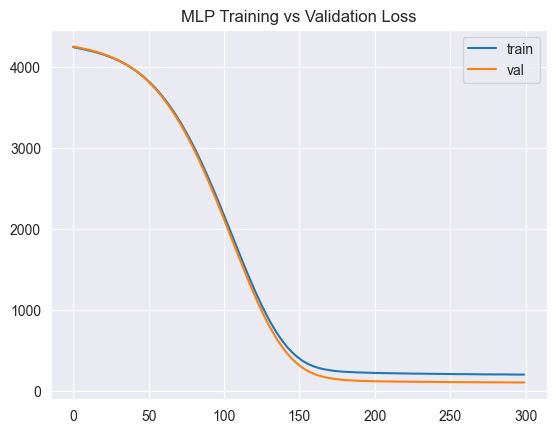

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("MLP Training vs Validation Loss")
plt.show()